# Global usage

MIMEco infers the interaction potential between two organisms using multi-objective metabolic modelling. This requires the user to input their genome-scale metabolic models (GEMs), and a specific medium is highly recommended to model relevant interactions. Here, we will explore an example for a global usage of MIMEco. 

## Models and medium definition
### Models
The two organisms must be inputted as cobrapy models. Cobrapy allows easy import of models of sbml, json, yaml, matlab and pickle formats.

In this example, we import two gut bacteria models: *Lactobacillus rhamnosus* and *Bifidobacterium adolescentis*

In [1]:
import cobra

model1 = cobra.io.read_sbml_model("resources/models/Lactobacillus_rhamnosus_GG_GG_ATCC_53103.xml")
model1.id = "L_rhamnosus"
model2 = cobra.io.read_sbml_model("resources/models/Bifidobacterium_adolescentis_ATCC_15703.xml")
model2.id = "B_adolescentis"

Set parameter WLSAccessID
Set parameter WLSSecret
Set parameter LicenseID to value 2640067
Academic license 2640067 - for non-commercial use only - registered to an___@ls2n.fr


It is better to immediatly change the model's solvers from glpk to a better one (gurobi, CPLEX or SCIP)

In [2]:
model1.solver = "gurobi"
model2.solver = "gurobi"

### Medium
The medium must be inputted in the form of a pandas dataframe where the index is the medium metabolite identifier, and the corresponding value is the availability of corresponding metabolite in the medium as a positive flux value (float).
Here, the medium represents a western diet, corresponding to a dietary intake rich in sugars and fats

In [3]:
import pandas as pd
Western_diet = pd.read_csv("resources/Western_diet_BiGG.csv", index_col = 0)

Western_diet

,Western_diet
adocbl,1.000000
ala__L,0.300000
amylose300,0.000078
arabinogal,0.000037
arachd,0.003867
...,...
ttdca,0.079798
tyr__L,0.099000
val__L,0.180000
vitd3,1.000000


If no medium is inputted, then the exchange reactions bounds will stay as in the inputted medium, which is highly unconstrained if you did not modify the model beforehand. 

### Undescribed metabolites constraint

In [4]:
print(len(model1.exchanges))
print(len(model2.exchanges))

163
119


L. rhamnosus has 163 exchange reactions, which means we can control the appearance of 163 metabolites in the external medium of the model. For B adolescentis, we have 119 exchange reactions. However, our Western diet only defines the appearance flux of 90 metabolites. All of the exchange metabolites present in the models, but not defined by the medium are "undescribed metabolites"

the **`undescribed_metabolites_constraint`** argument enables to chose the level of constraint applied to these metabolites, among the following options:
 - **`"blocked"`**: All undefined metabolites lower bounds are set to 0, blocking their appearance in the medium. This is the ideal option, as it only allow the bacteria to grow and interact on your designed medium.
 - **`"partially_constrained"`**: It can be tricky to define a medium that enables both organisms to grow in `blocked` conditions. Often, slightly unconstraining the undescribed metabolites appearance can help while still yielding medium-dependent results. This options allow a non-zero lower bound for undescribed metabolites. It is set as "-1" by default, but this lower_bound value can be personnalized through the option `undescribed_met_lb
 - **`"as_is"`**: In this case, the lower bound of undescribed metabolites exchange reactions stays the same as in the inputted model. This is usually highly unconstrained.

## Metabolic interaction inference

Let's infer the interaction score and type between *L. rhamnosus* and *B. adolescentis* with the function **`interaction_score_and_type()`**

In [5]:
from mimeco import analysis

int_score, int_type = analysis.interaction_score_and_type(model1, model2, Western_diet, 
                                                          undescribed_metabolites_constraint="partially constrained")
print("interaction score: ",int_score)
print("interaction type: ",int_type)

nb of bounds modified by medium :  46
(0, 1261)
(1, 2285)
/tmp/tmptcqcb3we
interaction score:  13.852285692407088
interaction type:  favors model1


The first output line indicates the number of exchange reactions that were changed based on the medium definition given as input. It serves as debugging purpose. You should note that any option other than "blocked" for the `undescribed_metabolites_constraint` argument will also modify the bounds of exchange reactions not described in the inputted medium; therefore increasing this number. 
The lines 2 to 4 are normal outputs from the dependency mocbapy, describing the Pareto front inference and where the temporary files folder.


This analysis predicts that the presence of B. adolescentis (model2) is beneficial to L. rhamnosus's (model1) growth in a pairwise ecosystem exposed to a Western diet. To better understand this result, it is possible to plot the Pareto front with the argument `plot  = True`:

nb of bounds modified by medium :  46
(0, 1261)
(1, 2285)
/tmp/tmpgd4f6mjp


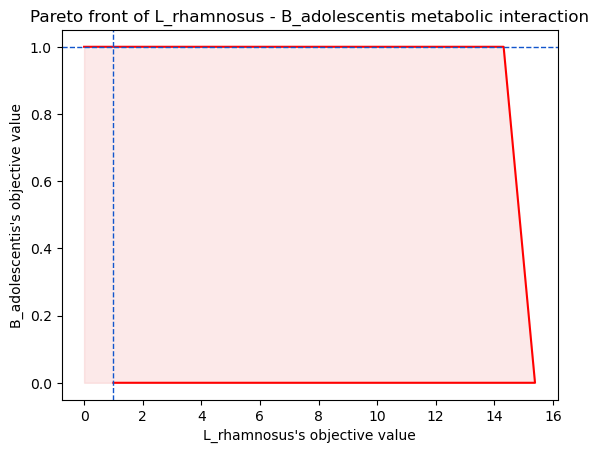

In [6]:
int_score, int_type = analysis.interaction_score_and_type(model1, model2, Western_diet, 
                                                          undescribed_metabolites_constraint="partially constrained", 
                                                          plot = True)


L. rhamnosus is highly benefitting from B. adolescentis presence. What metabolic exchanges could explain this ?

## Exchanged metabolites inference
The function `crossfed_metabolites()` predicts the metabolites that are exchanged between the organisms, and whose exchanges are correlated with model2's objective value. In other words, it infers the metabolic exchanges impacting model2's growth in ecosystem. 
This analysis requires more data from the user, and is more time consuming.
This function also takes **`model1`**, **`model2`**, **`medium`** and **`undescribed_metabolites_constraint`** as arguments. 
It also needs:
 - **`solver`**: precise the solver you are using.
 - **`model1_biomass_id`**: id of the reaction used as objective in model1 (if the objective coefficient is not null for several reactions, then a new reaction must be built to constrain the model to a given objective value through its flux)
 - **`model2_biomass_id`**

The function identifies crossfed metabolites. These are metabolites that are secreted by one organism and uptaken by the other in a given proportion of the set of metabolic phenotypes (ie. solutions). Their transport reaction fluxes are correlated with the biomass objective value.

In a nutshell, these are metablites that are exchanged between organisms, and this exchange impacts model2's fitness. 

This function requires a large number of optimizations and teh building of a correlation matrix. Therefore, it should take around five minutes to run locally on a computer.

In [7]:
model1_biomass_id = "Growth"
model2_biomass_id = "Growth"

potential_exchange = analysis.crossfed_metabolites(model1 = model1, model2 = model2, medium = Western_diet, undescribed_metabolites_constraint = "partially_constrained",
                               solver = "gurobi", model1_biomass_id = model1_biomass_id, model2_biomass_id = model2_biomass_id)

potential_exchange

nb of bounds modified by medium :  185
(0, 1261)
(1, 2285)
/tmp/tmpotd0tq9f


/home/anna/.local/lib/python3.10/site-packages/cobra/util/solver.py:554: UserWarning: Solver status is 'infeasible'.
  warn(f"Solver status is '{status}'.", UserWarning)


{'ser__L': [0.961038961038961, 0.961038961038961, 0.0]}

the function returns the `potential_exchange` dictionnary. Its keys are identified crossfed metabolites. The values are lists of three elements :
 - The proportion of metabolic phenotype on the Pareto front in which these metabolites are echanged
 - The proportion of metabolic phenotypes where the exchange goes from model1 to model2
 - The proportion of metabolic phenotypes where the exchange goes from model2 to model1

This enables to identify crossfed metabolites, the frequence of this exchange on the Pareto front, and its direction. Here, serine is exchanged in 96% of the metabolic phenotypes highlighted by the pareto front, and this exchange goes from L. rhamnosus to B. adolescentis. 

To better explore the evolution of these crossfed metabolites transport along the Pareto front, a plotting function is included as on option:

nb of bounds modified by medium :  185
(0, 1261)
(1, 2285)
/tmp/tmp36mfkens


/home/anna/.local/lib/python3.10/site-packages/cobra/util/solver.py:554: UserWarning: Solver status is 'infeasible'.
  warn(f"Solver status is '{status}'.", UserWarning)


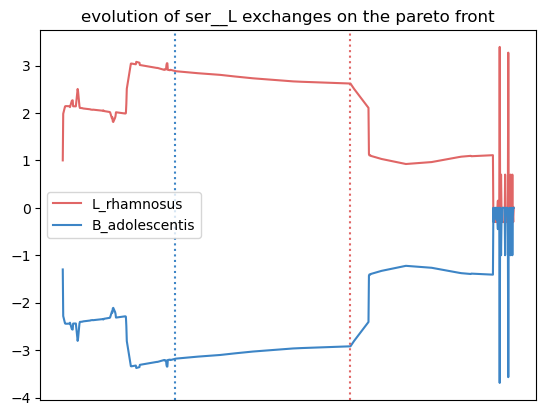

<Figure size 640x480 with 0 Axes>

In [ ]:
potential_exchange = analysis.crossfed_metabolites(model1 = model1, model2 = model2, medium = Western_diet, undescribed_metabolites_constraint = "partially_constrained",
                               solver = "gurobi", model1_biomass_id = model1_biomass_id, model2_biomass_id = model2_biomass_id, plot = True)

In this plot, the transport flux of serine in and out of model1 (L. rhamnosus) is represented in red. The x axis is the parsing of the Pareto front. Horizontal dotted lines mark the point on the Pareto with the highest objective value for the corresponding organism. Finally, a positive flux value represents the secretion of the metabolite, and a negative value represents an uptake.
In this example, L. rhamnosus secretes serine, which is uptaken at a corresponding rate by B. adolescentis. This is the case at both objective value's optimum.

Now, this analysis identifies crossfed metabolites associated with the fitness of model2. Let's repeat the process by exchanging model1 and model2 in the arguments of the function:

nb of bounds modified by medium :  185
(0, 1022)
(1, 2285)
/tmp/tmp59cjlt14


/home/anna/.local/lib/python3.10/site-packages/cobra/util/solver.py:554: UserWarning: Solver status is 'infeasible'.
  warn(f"Solver status is '{status}'.", UserWarning)


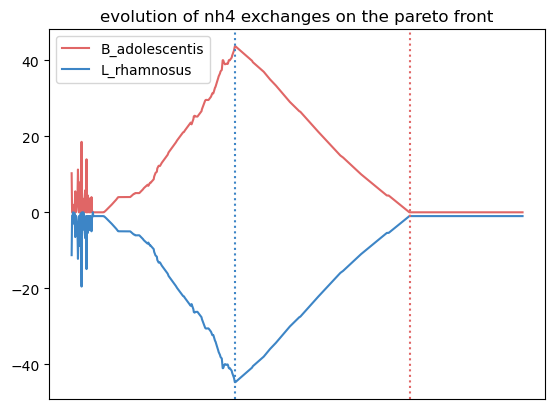

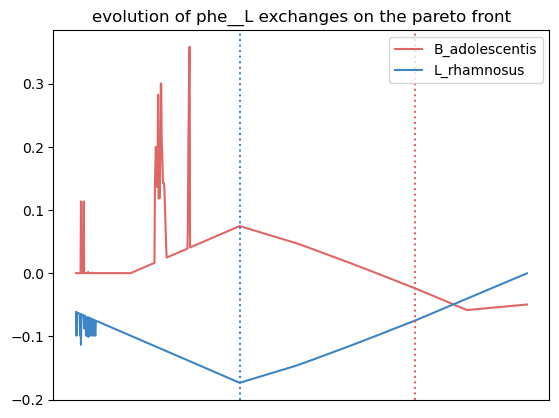

<Figure size 640x480 with 0 Axes>

In [9]:
potential_exchange2 = analysis.crossfed_metabolites(model1 = model2, model2 = model1, medium = Western_diet, undescribed_metabolites_constraint = "partially_constrained",
                               solver = "gurobi", model1_biomass_id = model1_biomass_id, model2_biomass_id = model2_biomass_id, plot = True)

Here, we observe that the growth of L. rhamnosus is favored by the crossfeeding of amonium and phenylalanine from B. adolescentis. 

### Options to calibrate the analysis

The crossfed metabolites analysis is based on the sampling of metabolic phenotypes on the Pareto front. By default, 1000 metabolic phenotypes are sampled, but it can be changed using the optional argument **`sample_size`**.

The selection of crossfed metabolites (CM) can be personnalized. 
The exact criteria, and their modulable options are:

 - the fluxes of the CM transport reactions for the two organisms are anti-correlated.

    By default, the anti-correlation must be superior or equal to 0.5. This can be changed using the optionnal argument **`exchange_correlation`**.

 - The fluxes of the CM transport reactions for the two organisms are correlated with model2 biomass production.

    By default, a minimal correlation value is set to 0.8. This can be changed using the optional argument **`biomass_correlation`**.

 - The reactions yield opposite sign for a given proportion of solutions.

    By default, the minimal proportion of metabolic phenotypes where transport reactions yield opposite sign is set to 0.3. This can be changed using the optionnal argument **`lower_exchange_proportion`**.

Let's to see if the results change when largely unconstraining these parameters:

In [ ]:
potential_exchange2 = analysis.crossfed_metabolites(model1 = model2, model2 = model1, medium = Western_diet, undescribed_metabolites_constraint = "partially_constrained",
                                                    solver = "gurobi", model1_biomass_id = model2_biomass_id, model2_biomass_id = model1_biomass_id, 
                                                    exchange_correlation = 0.3, biomass_correlation = 0.6, lower_exchange_proportion = 0.1)
potential_exchange2

nb of bounds modified by medium :  185
(0, 1022)
(1, 2285)
/tmp/tmp0ba3c0c8


/home/anna/.local/lib/python3.10/site-packages/cobra/util/solver.py:554: UserWarning: Solver status is 'infeasible'.
  warn(f"Solver status is '{status}'.", UserWarning)


nb of bounds modified by medium :  185
(0, 1022)
(1, 2285)
/tmp/tmpts0_4wlj


/home/anna/.local/lib/python3.10/site-packages/cobra/util/solver.py:554: UserWarning: Solver status is 'infeasible'.
  warn(f"Solver status is '{status}'.", UserWarning)


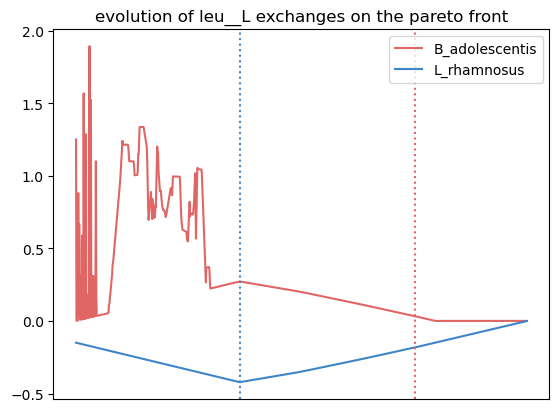

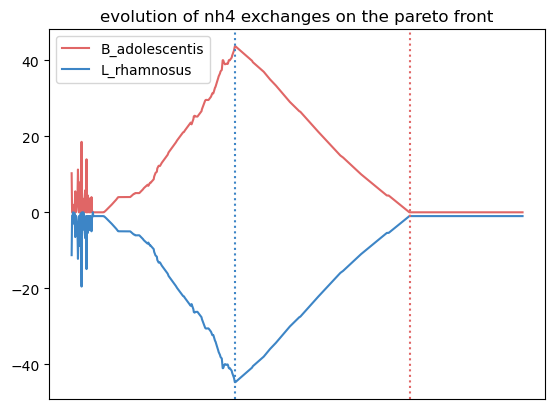

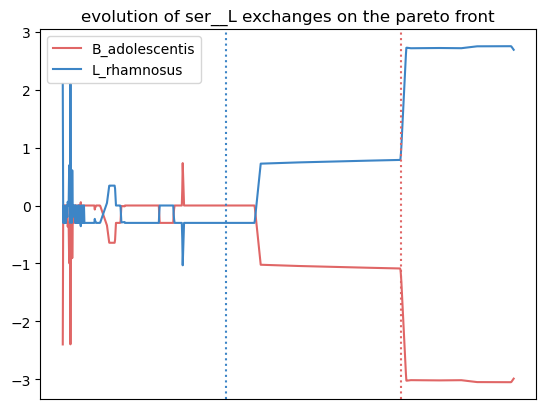

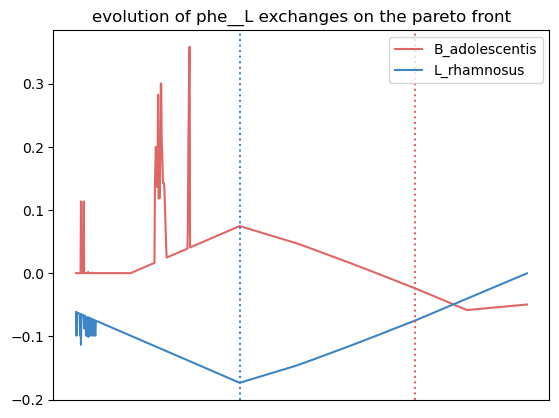

{'leu__L': [0.7962037962037962, 0.7962037962037962, 0.0],
 'nh4': [0.7262737262737263, 0.7262737262737263, 0.0],
 'ser__L': [0.6043956043956044, 0.005994005994005994, 0.5984015984015985],
 'phe__L': [0.5484515484515484, 0.5484515484515484, 0.0]}

<Figure size 640x480 with 0 Axes>

In [12]:
potential_exchange2 = analysis.crossfed_metabolites(model1 = model2, model2 = model1, medium = Western_diet, undescribed_metabolites_constraint = "partially_constrained",
                                                    solver = "gurobi", model1_biomass_id = model1_biomass_id, model2_biomass_id = model2_biomass_id, 
                                                    exchange_correlation = 0.3, biomass_correlation = 0.6, lower_exchange_proportion = 0.1, plot = True)
potential_exchange2

We observe more crossfed metabolites (leucine and serine), but as the criteria were less stringent, their exchange is less clear, but still holds potential, especifically at optimal growth values. 

## Extracting data to do further analysis

It is possible to extract data generated by the sampling of the Pareto front to freely analyze the metabolic behaviors of the pairwize ecosystem. In this case, the `crossfed_metabolites()` function returns both the `potential_crossfeeding` dictionnary and the `sampling_data` pandas dataframe.
The optional argument ``retrieve_data can be set to:
 - **"all"**, where the whole sampling matrix is returned in a second variable
 - **"selection"** where the a pandas dataframe of the sampling of selected crossfed metabolites transport reactions and both organisms biomass reactions is returned. 